In [ ]:
#https://www.kaggle.com/datasets/mehdinait/audio-sample-language-classification
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display as display
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix
import pickle

In [ ]:
#!unzip '/content/drive/MyDrive/AudioClassification/LanguageClassification.zip' -d '/content/drive/MyDrive/AudioClassification'

In [ ]:
os.listdir("/content/drive/MyDrive/AudioClassification/Dataset")[:5]

['AR_0002.wav', '0Info.txt', 'AR_0003.wav', 'AR_0012.wav', 'AR_0023.wav']

In [ ]:
labels=open('/content/drive/MyDrive/AudioClassification/Dataset/0Info.txt','r')
l=labels.readline()
id=[]
label=[]
while(l!=''):
  line=l.split(',')
  id.append(line[0])
  label.append(line[3])
  l=labels.readline()
labels.close()

In [ ]:
id=np.array(id)
label=np.array(label)
unique=np.unique(label)

In [ ]:
fpath='/content/drive/MyDrive/AudioClassification/Dataset/'
audio=[]
for i in id:
  x,sr=librosa.load(fpath+i,sr=16000)
  audio.append(x)
audio=np.array(audio)

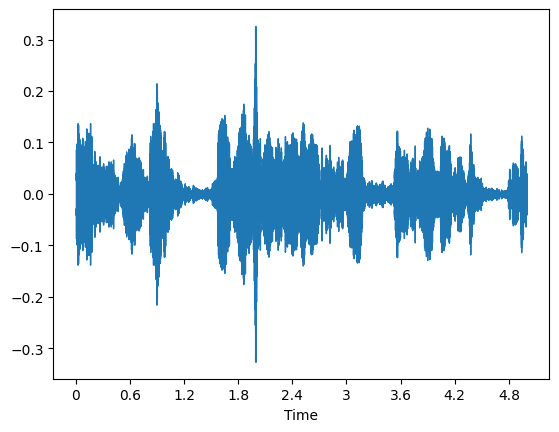

In [ ]:
librosa.display.waveshow(audio[5],sr=sr)

In [ ]:
audio_transformed=librosa.stft(audio)

In [ ]:
audio_transformed.shape

(1000, 1025, 157)

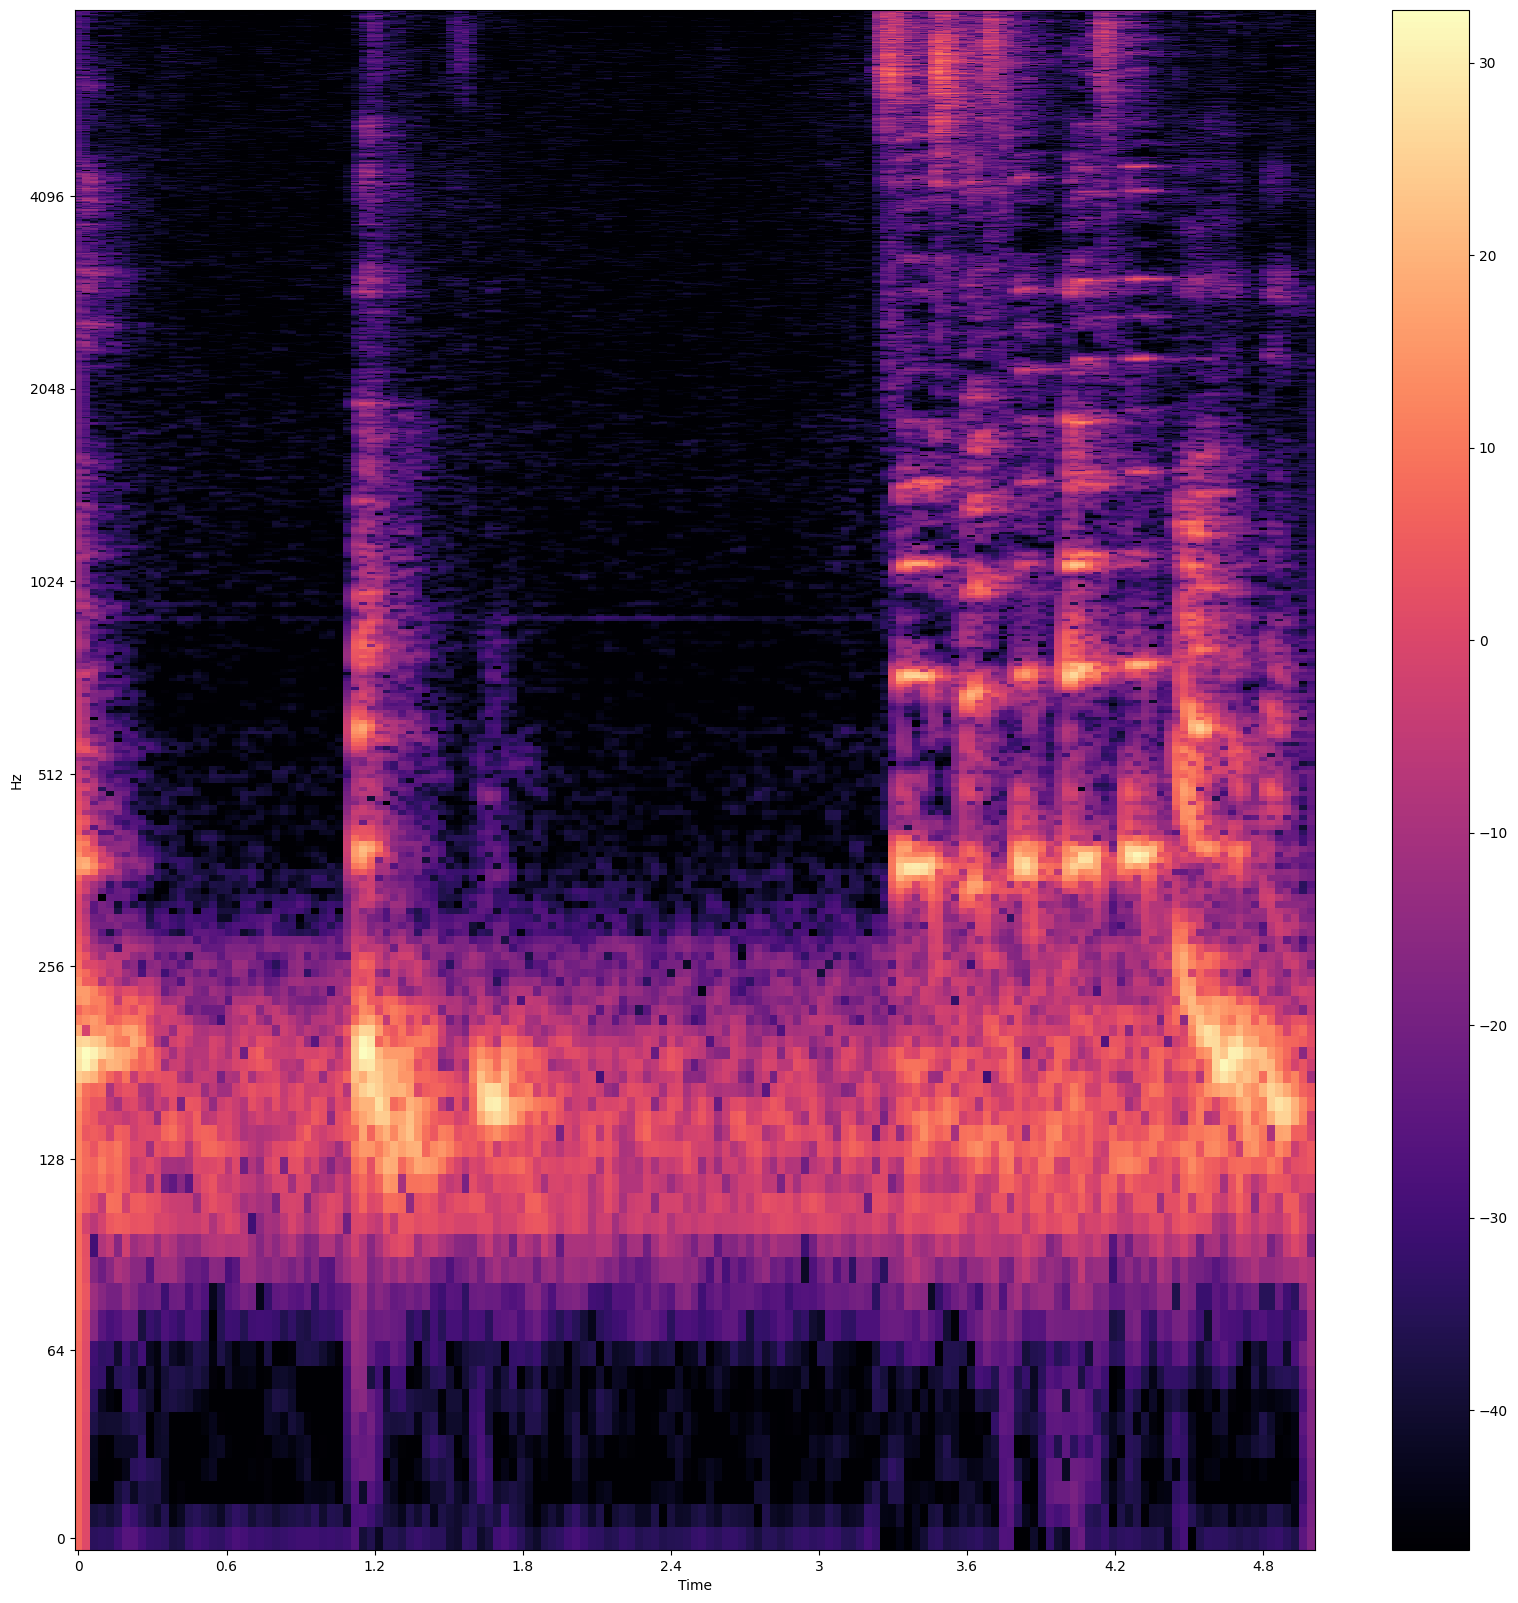

In [ ]:
Xdb = librosa.amplitude_to_db(abs(audio_transformed[10]))
plt.figure(figsize=(20,20))
librosa.display.specshow(Xdb,sr=16000,y_axis='log',x_axis='time')
plt.colorbar()
#plt.savefig(fpath+'/Spectrograms/TestImage.png')

In [ ]:
audio_test=librosa.amplitude_to_db(abs(audio_transformed))

In [ ]:
def spec_to_img(audio_test):
  c=0
  for i in audio_test:
    plt.figure(figsize=(20,20))
    librosa.display.specshow(i,sr=16000,y_axis='log',x_axis='time')
    plt.colorbar()
    plt.savefig(fpath+'/Spectrograms/'+id[c]+'.png')
    plt.close()
    c=c+1

In [ ]:
os.listdir(fpath+'/Spectrograms')[:5]

['JP_0000.wav.png',
 'JP_0001.wav.png',
 'JP_0003.wav.png',
 'JP_0002.wav.png',
 'JP_0006.wav.png']

In [ ]:
l=['JP']*250+['FR']*250+['EN']*250+['AR']*250
label=l

In [ ]:
#LE=LabelEncoder()
#label=LE.fit_transform(label)

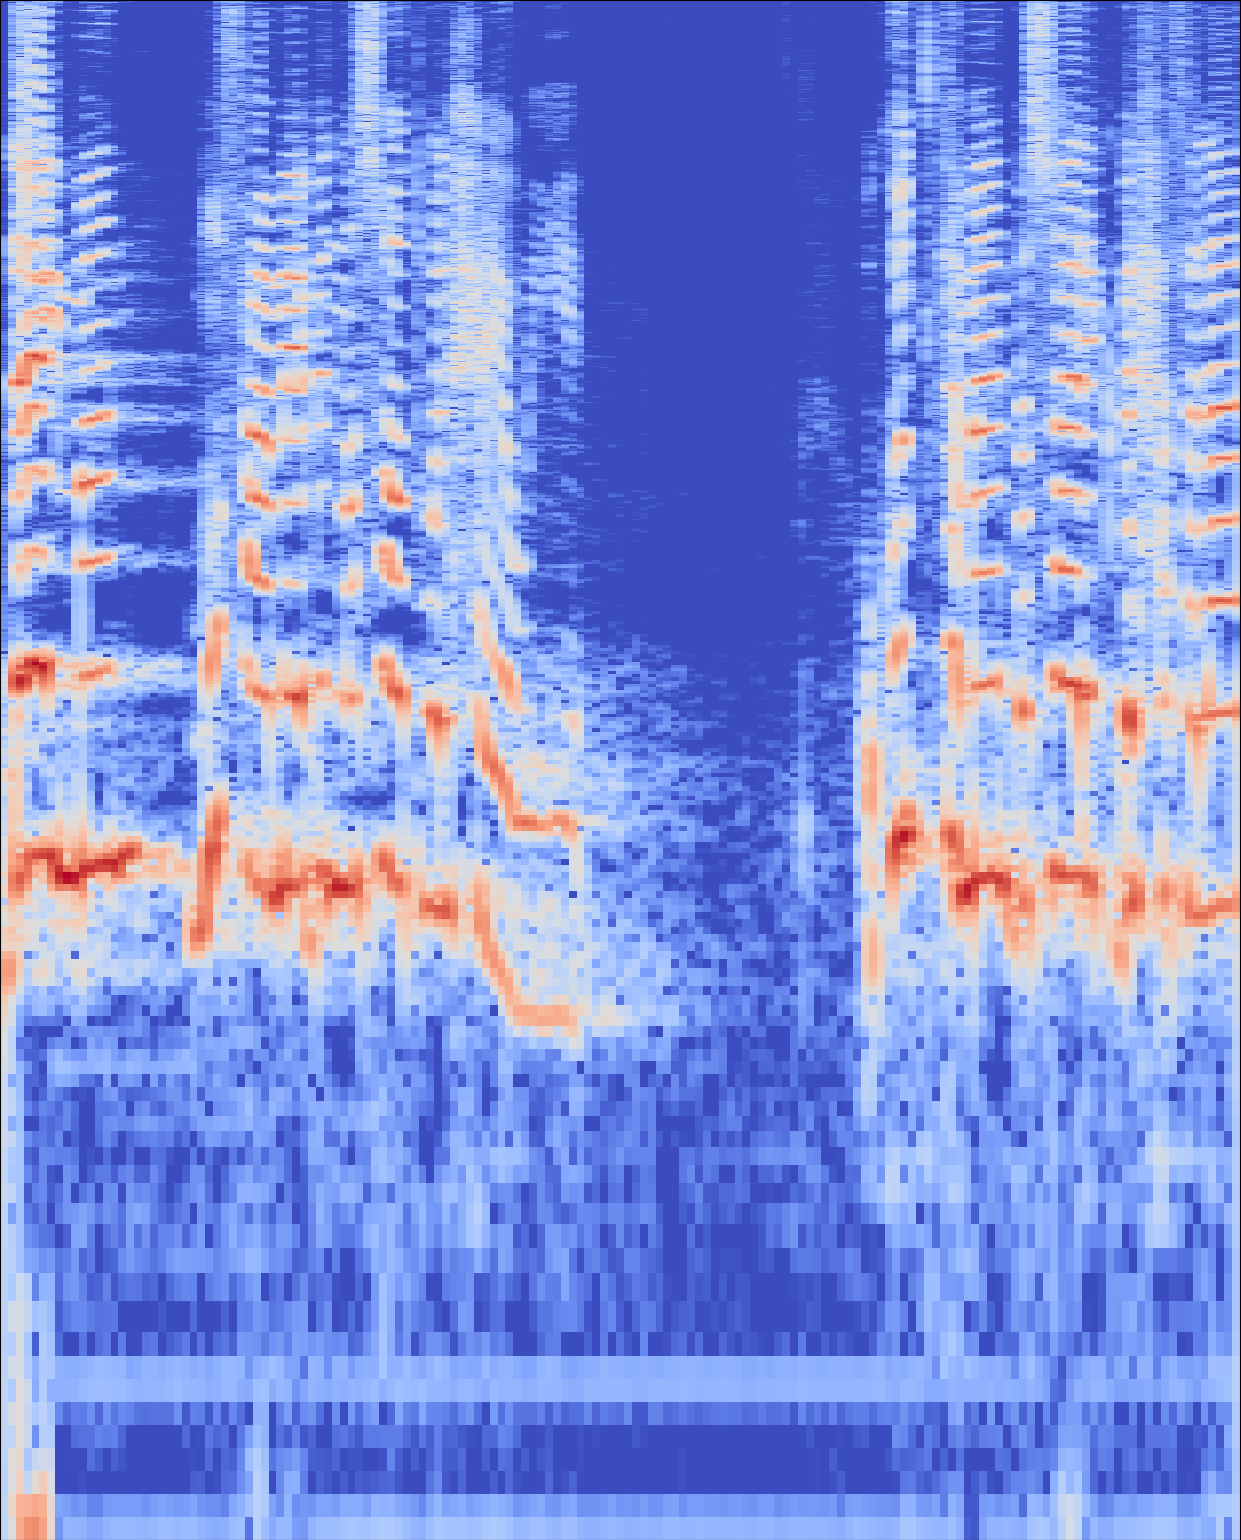

In [ ]:
display.Image(fpath+'/Spectrograms/AR_0191.wav.png')

In [ ]:
languages=np.unique(label)
languages

array(['AR', 'EN', 'FR', 'JP'], dtype='<U2')

In [ ]:
boolean_labels=[i==languages for i in label]
boolean_labels[0:10]

[array([False, False, False,  True]),
 array([False, False, False,  True]),
 array([False, False, False,  True]),
 array([False, False, False,  True]),
 array([False, False, False,  True]),
 array([False, False, False,  True]),
 array([False, False, False,  True]),
 array([False, False, False,  True]),
 array([False, False, False,  True]),
 array([False, False, False,  True])]

In [ ]:
filenames=[fpath+'Spectrograms/'+i for i in os.listdir(fpath+'/Spectrograms/')]
filenames[:5]

['/content/drive/MyDrive/AudioClassification/Dataset/Spectrograms/JP_0000.wav.png',
 '/content/drive/MyDrive/AudioClassification/Dataset/Spectrograms/JP_0001.wav.png',
 '/content/drive/MyDrive/AudioClassification/Dataset/Spectrograms/JP_0003.wav.png',
 '/content/drive/MyDrive/AudioClassification/Dataset/Spectrograms/JP_0002.wav.png',
 '/content/drive/MyDrive/AudioClassification/Dataset/Spectrograms/JP_0006.wav.png']

In [ ]:
X=filenames
y=boolean_labels

In [ ]:
np.random.seed(42)
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2)

In [ ]:
def crop(file):
  img=cv2.imread(file)
  #print(img.shape)
  #cv2_imshow(img)
  cropped_image=img[240:1780,250:1491]
  cv2.imwrite(file,cropped_image)
  #cv2_imshow(cropped_image)

In [ ]:
'''
for i in filenames:
  crop(i)
'''

'\nfor i in filenames:\n  crop(i)\n'

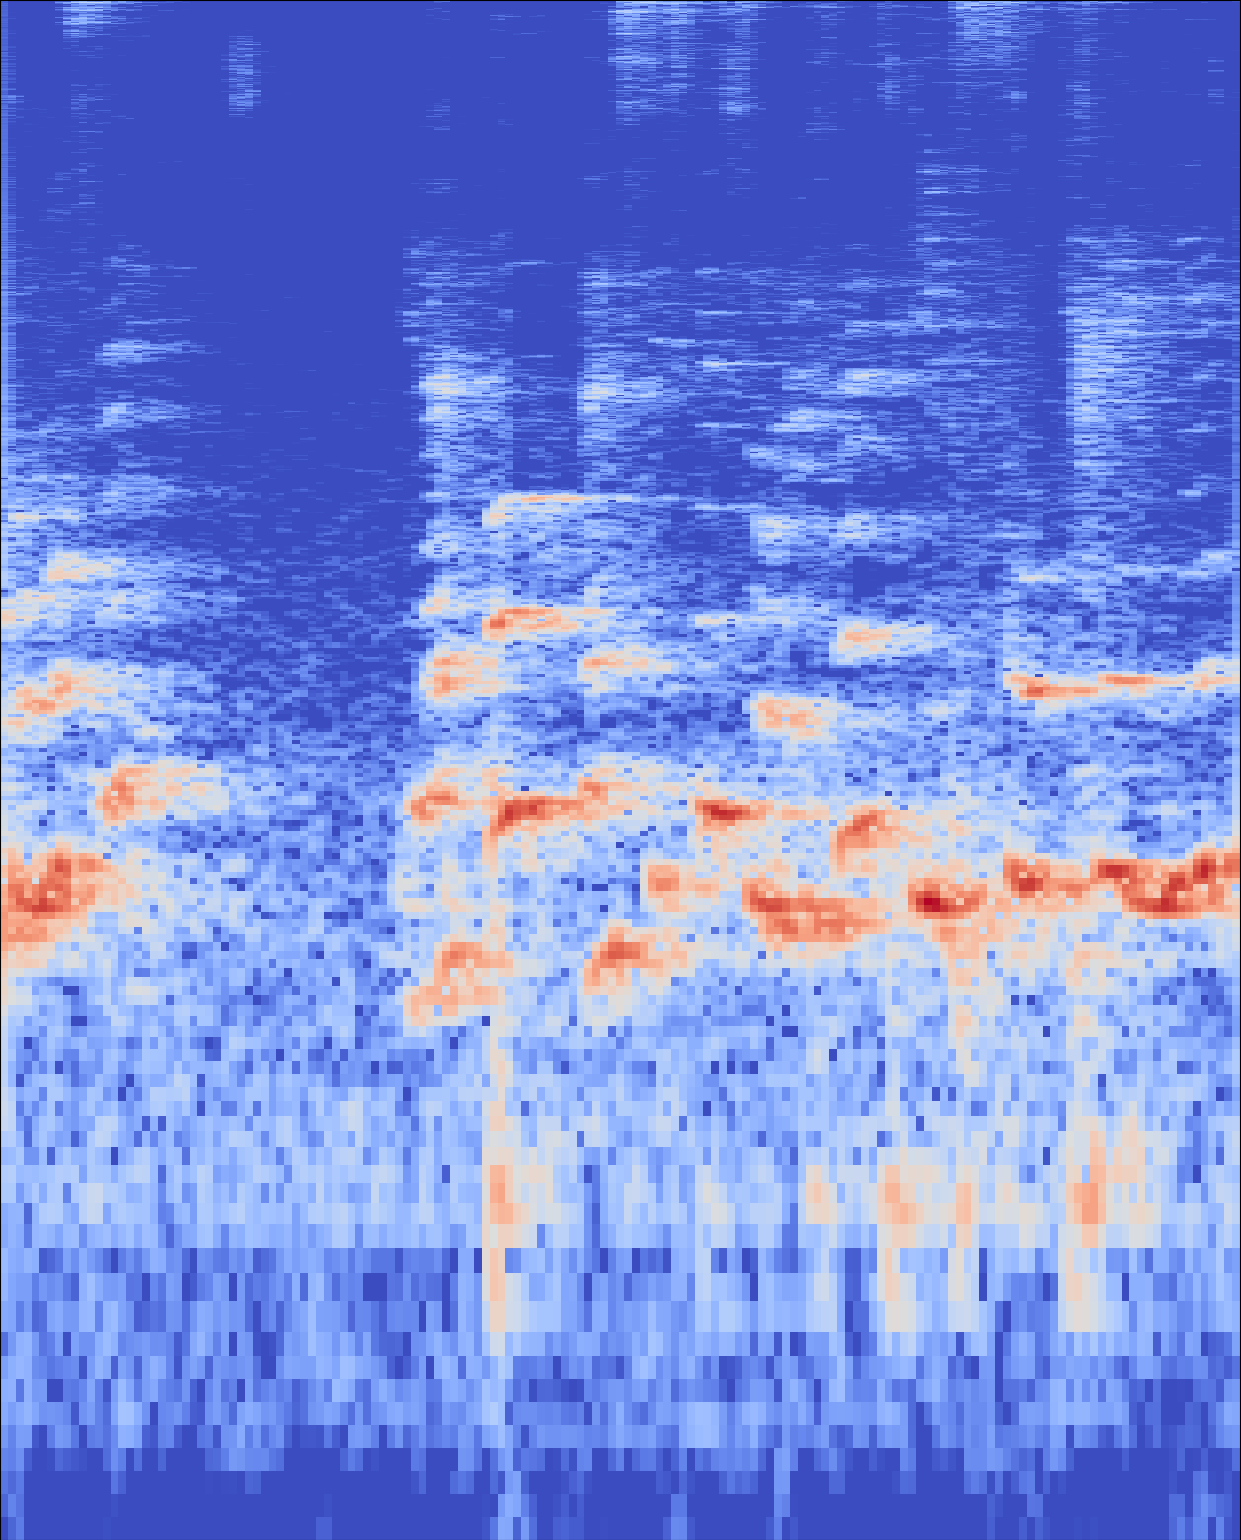

In [ ]:
image=cv2.imread(filenames[490])
cv2_imshow(image)

In [ ]:
image[0][:5]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [ ]:
#Define an image size
IMG_SIZE=224
#Create a function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path an return a tensor
  """
  #Read in an image file
  image=tf.io.read_file(image_path)
  # Turn the image into a numerical tensor with 3 color channels
  image=tf.image.decode_png(image,channels=3)
  #Convert the color channel values from 0-255 to 0-1 values
  image=tf.image.convert_image_dtype(image,tf.float32)
  #Resize image to (224,224)
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
  return image

In [ ]:
##Create a simple function to return a tuple(image,label)
def get_image_label(image_path,label):
  """
  Takes an image path and the associated label, processes the image and returns a tuple of (image,label)
  """
  image=process_image(image_path)
  return image,label

In [ ]:
#Define the batch size
BATCH_SIZE=32
#Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
train_data=create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val,valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
import matplotlib.pyplot as plt
def show_25_images(images,labels):
  """
  Display a plot of 25 images and their labels from a data branch
  """
  #Setup the figure
  plt.figure(figsize=(10,15))
  for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique[labels[i].argmax()])
    #Turn the gridlines off
    plt.axis('off')

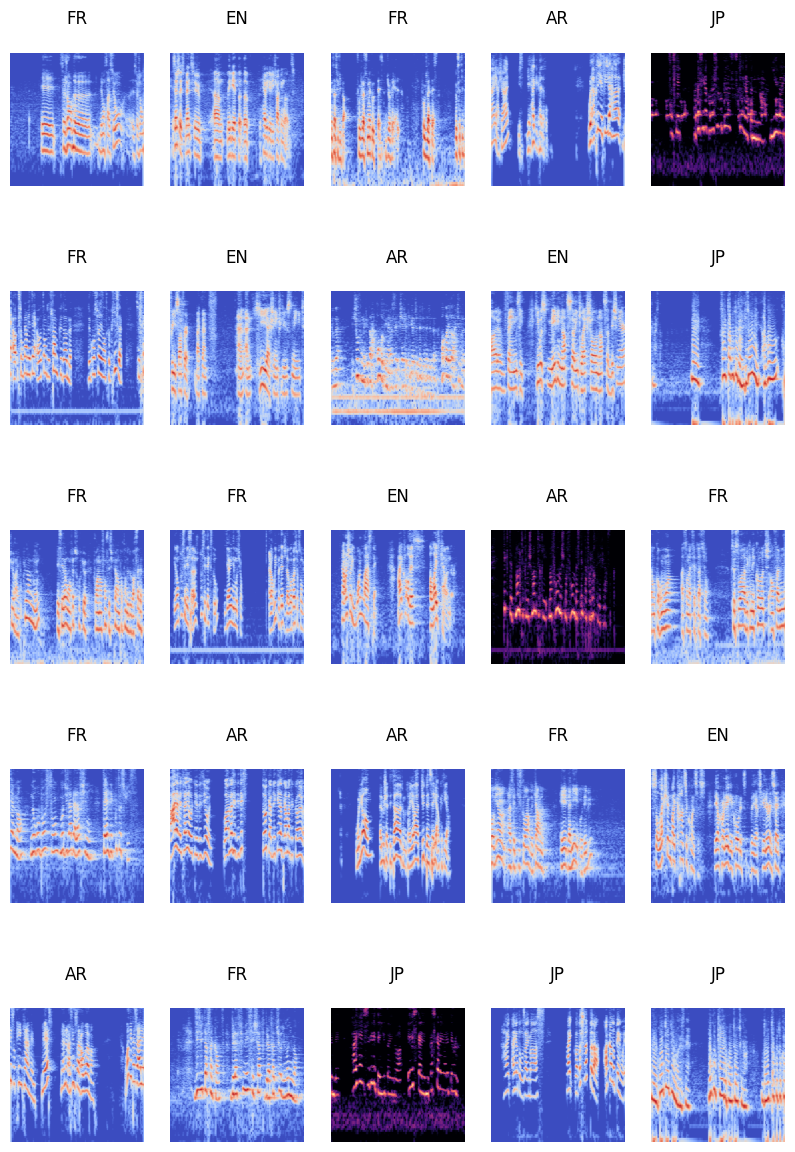

In [ ]:
train_images,train_labels=next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

In [ ]:
#Setup input shape to the model
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3]#batch,height,width,color channels
OUTPUT_SHAPE=len(unique)
#Setup model URL from tensorflow hub
MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
#Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("Building model with :",MODEL_URL)
  #Setup the model layers
  model=tf.keras.Sequential([hub.KerasLayer(MODEL_URL),tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax")])#Layer 2 output layer
  #Compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
  model.build(INPUT_SHAPE)
  return model

In [ ]:
model=create_model()
model.summary()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 4)                 4008      
                                                                 
Total params: 5436721 (20.74 MB)
Trainable params: 4008 (15.66 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [ ]:
import datetime
#Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  logdir=os.path.join("/content/drive/MyDrive/dog vision/logs")
  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

In [ ]:
#Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  #Create a model
  model=create_model()
  #Create new TensorBoard session everytime we train a model
  tensorboard=create_tensorboard_callback()
  model.fit(x=train_data,epochs=50,validation_data=val_data,validation_freq=1,callbacks=[tensorboard,early_stopping])
  return model

In [ ]:
NUM_EPOCHS=len(train_data)

In [ ]:
#model=train_model()

In [ ]:
#model.save('/content/drive/MyDrive/AudioClassification/Saved Models/cnn_imagenet_model.keras')

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/AudioClassification/Saved Models/cnn_imagenet_model.keras',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
predictions=model.predict(val_data,verbose=1)

7/7 [==============================] - 7s 857ms/step


In [ ]:
predictions.shape

(200, 4)

In [ ]:
#First prediction
index=42
print(f"Max value (probability of prediction):{np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index:{np.argmax(predictions[index])}")
print(f"Predicted label:{unique[np.argmax(predictions[index])]}")

Max value (probability of prediction):0.8452486991882324
Sum:1.0000001192092896
Max index:2
Predicted label:FR



In [ ]:
final_predictions=[]
for i in predictions:
  l=[0]*4
  l[np.argmax(i)]=1
  final_predictions.append(l)
final_predictions[:5]

[[0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]

In [ ]:
np.argmax(y_val,axis=1)

array([1, 1, 1, 1, 2, 1, 1, 1, 0, 3, 0, 3, 1, 0, 0, 0, 2, 0, 0, 2, 1, 3,
       2, 1, 3, 3, 3, 0, 0, 0, 2, 3, 1, 2, 2, 3, 1, 1, 0, 3, 2, 3, 2, 0,
       2, 2, 0, 1, 2, 0, 1, 0, 2, 1, 3, 3, 1, 3, 3, 0, 2, 3, 1, 3, 1, 1,
       1, 0, 3, 1, 3, 2, 1, 1, 2, 2, 1, 3, 1, 2, 1, 3, 2, 3, 2, 1, 0, 1,
       0, 2, 2, 2, 1, 3, 0, 2, 0, 3, 3, 0, 1, 2, 0, 2, 1, 1, 1, 0, 3, 0,
       1, 0, 0, 0, 3, 2, 3, 0, 1, 2, 0, 2, 1, 2, 3, 1, 1, 2, 0, 0, 1, 0,
       2, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 0, 0, 0, 3, 0, 2, 1, 3, 0, 2,
       0, 2, 2, 1, 3, 0, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 3, 0, 2, 2,
       2, 2, 0, 1, 2, 1, 2, 1, 0, 3, 2, 2, 0, 1, 0, 0, 1, 3, 3, 2, 2, 3,
       1, 3])

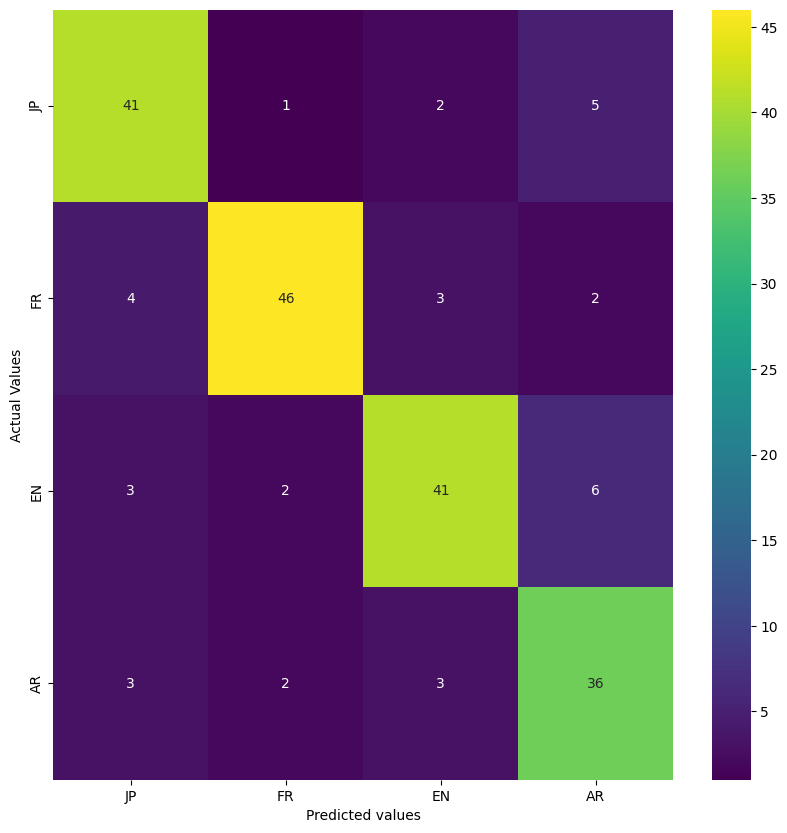

In [ ]:
conf_mat=confusion_matrix(y_pred=np.argmax(final_predictions,axis=1),y_true=np.argmax(y_val,axis=1))
fig,ax=plt.subplots(figsize=(10,10))
ax=sns.heatmap(pd.DataFrame(data=conf_mat,columns=['JP','FR','EN','AR'],index=['JP','FR','EN','AR']),annot=True,fmt='d',cmap='viridis')
plt.xlabel('Predicted values')
plt.ylabel('Actual Values')
plt.show()